In [11]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from prelim_experiments.param_experiments.chaney_utils import (
    load_sim_results,
    graph_relative_to_ideal,
    merge_results,
    graph_metrics,
    graph_metrics_by_axis,
    graph_relative_to_global_by_axis,
    transform_relative_to_global,
    graph_histogram_metric_by_axis,
    graph_averaged_metric_by_axis
)
from wrapper.models.bubble import BubbleBurster
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from param_experiments.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools

In [12]:
DEBUG = True # don't save figures

In [29]:
results_path = ["prelim_exp_results/repeated_training", "prelim_exp_results/repeated_training_user_cluster_mapping", "prelim_exp_results/repeated_training_user_cluster_mapping_10clusters"]
results_file = ["sim_results.pkl"] * len(results_path)
# environment_file = ["sim_environment.pkl", "sim_environment.pkl"]
# diagnostics_file = ["sim_diagnostics.pkl", "sim_diagnostics.pkl"]

results = merge_results(results_path, results_file)

metrics = list(results.keys())
print("# metrics =", len(metrics))
print(metrics)

models = list(results[metrics[0]].keys())
print("# models =", len(models))
print(models)

id_to_readable = dict(zip(models, models))
print(id_to_readable)

# metrics = 19
['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity', 'mean_global_cosine_sim', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cosine_sim_per_cluster', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid', 'mean_distance_from_centroid_per_cluster', 'interaction_histogram', 'rmse', 'mean_novelty', 'mean_slate_topic_diversity', 'topic_interaction_histogram', 'topic_interaction_spread', 'mse_per_user']
# models = 3
['0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping', '0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_0user-topic-mapping', '0.1drift_-0.8attention_1retraining_20attributes_10clusters_0surprise_0user-topic-mapping']


['0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping', '0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_0user-topic-mapping', '0.1drift_-0.8attention_1retraining_20attributes_10clusters_0surprise_0user-topic-mapping']


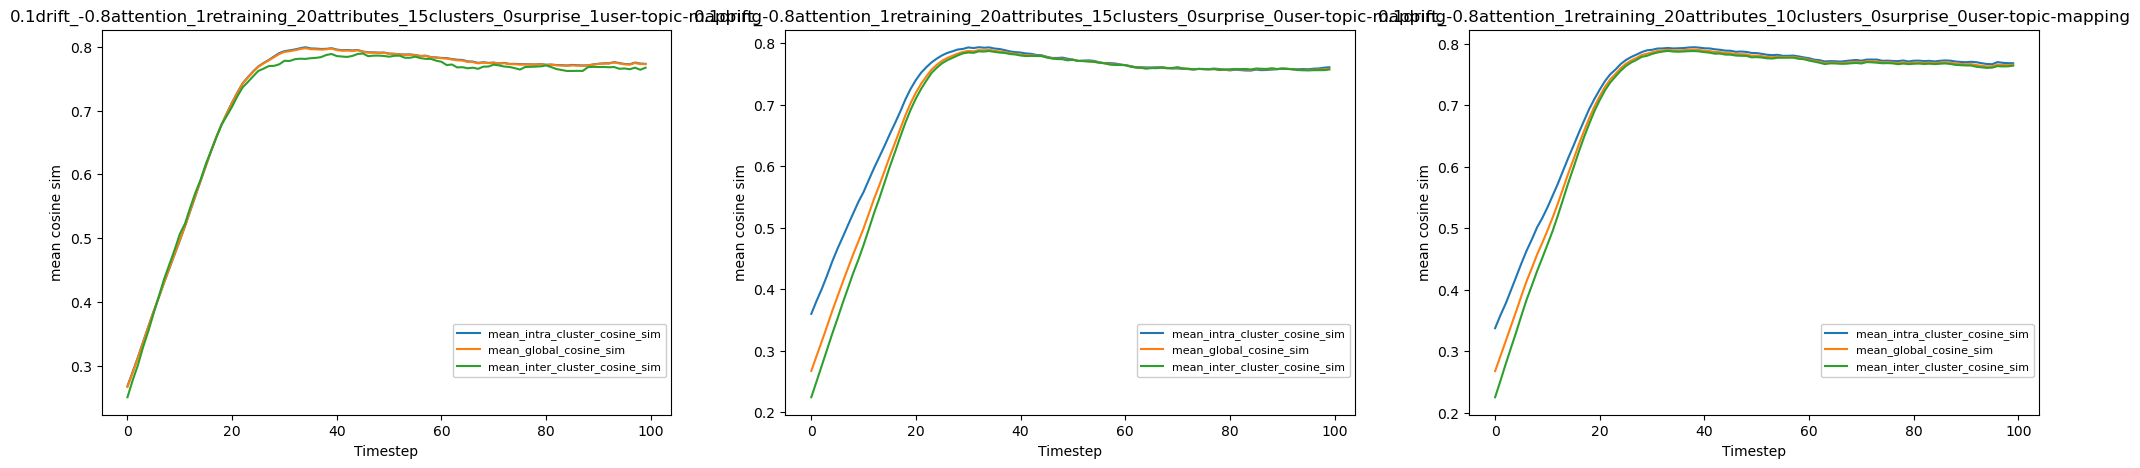

In [30]:
title = "Mean cosine sim"
metric_keys = ["mean_intra_cluster_cosine_sim", "mean_global_cosine_sim", "mean_inter_cluster_cosine_sim"]

print(models)
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

graph_metrics_by_axis(axs[0], results, metric_keys[0], [models[0]], id_to_readable, label="by_metric")
graph_metrics_by_axis(axs[0], results, metric_keys[1], [models[0]], id_to_readable, label="by_metric")
graph_metrics_by_axis(axs[0], results, metric_keys[2], [models[0]], id_to_readable, label="by_metric")
axs[0].set_ylabel('mean cosine sim')
axs[0].set_xlabel("Timestep")
axs[0].set_title(f"{models[0]}")
axs[0].legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(1, 0.25), fontsize="8",)

graph_metrics_by_axis(axs[1], results, metric_keys[0], [models[1]], id_to_readable, label="by_metric")
graph_metrics_by_axis(axs[1], results, metric_keys[1], [models[1]], id_to_readable, label="by_metric")
graph_metrics_by_axis(axs[1], results, metric_keys[2], [models[1]], id_to_readable, label="by_metric")
axs[1].set_ylabel('mean cosine sim')
axs[1].set_xlabel("Timestep")
axs[1].set_title(f"{models[1]}")
axs[1].legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(1, 0.25), fontsize="8",)

graph_metrics_by_axis(axs[2], results, metric_keys[0], [models[2]], id_to_readable, label="by_metric")
graph_metrics_by_axis(axs[2], results, metric_keys[1], [models[2]], id_to_readable, label="by_metric")
graph_metrics_by_axis(axs[2], results, metric_keys[2], [models[2]], id_to_readable, label="by_metric")
axs[2].set_ylabel('mean cosine sim')
axs[2].set_xlabel("Timestep")
axs[2].set_title(f"{models[2]}")
axs[2].legend(facecolor='white', framealpha=1, loc='best', bbox_to_anchor=(1, 0.25), fontsize="8",)

[1]


TypeError: 'AxesSubplot' object is not subscriptable

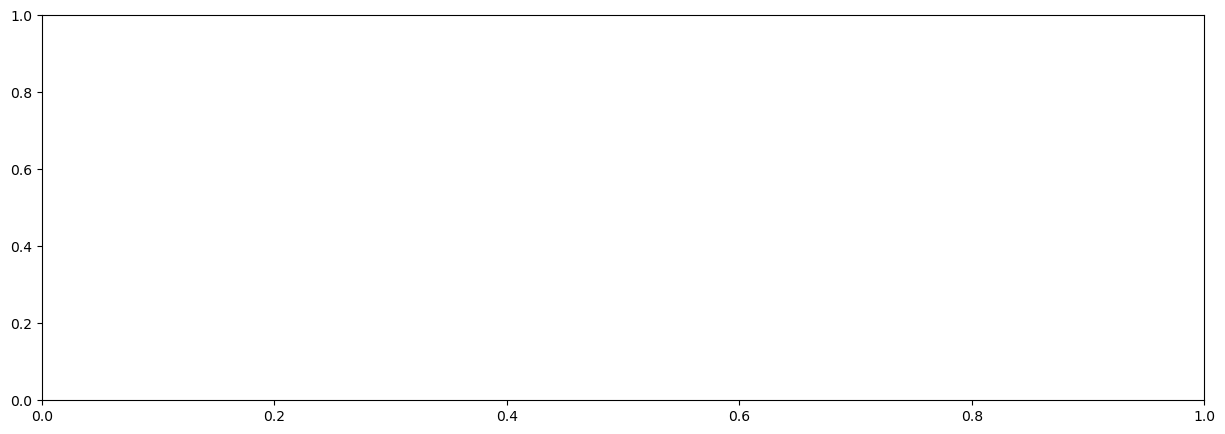

In [ ]:
hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])
print(hyper_param_values)
num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    graph_metrics_by_axis(axs[i], results, metric_key, model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"{metric_key}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, -0.15), fontsize="8",)


repeated_training=0
mse 1.31108

repeated_training=1
mse 1.21898


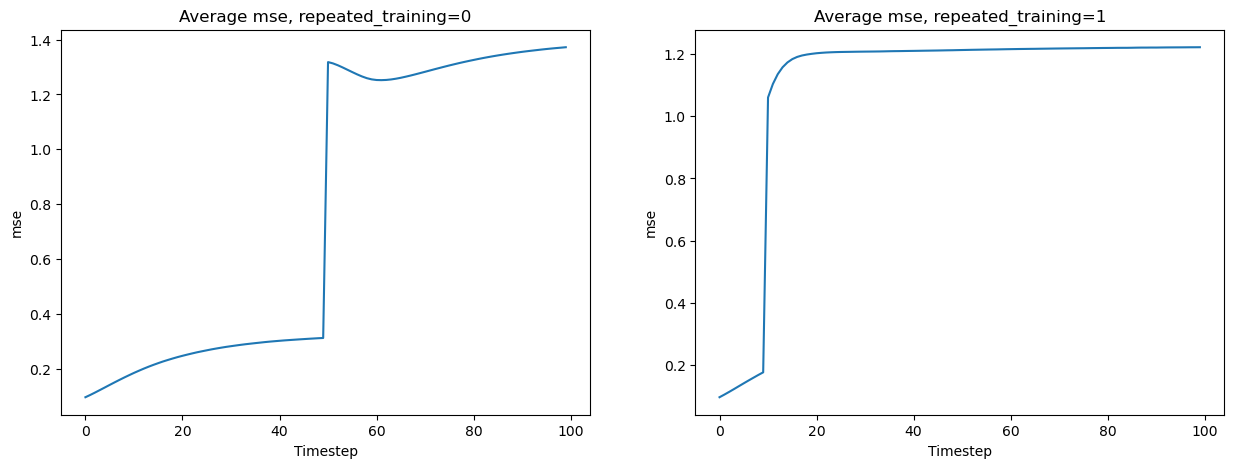

In [ ]:
# Which hyper-param to graph by
# graph_by_hyper_param = "drift"
# metric_key = "mse"

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_key, model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, mean_range=50)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {metric_key}, {graph_by_hyper_param}={param_val}")

## `Cosine similarity`


repeated_training=1


TypeError: 'AxesSubplot' object is not subscriptable

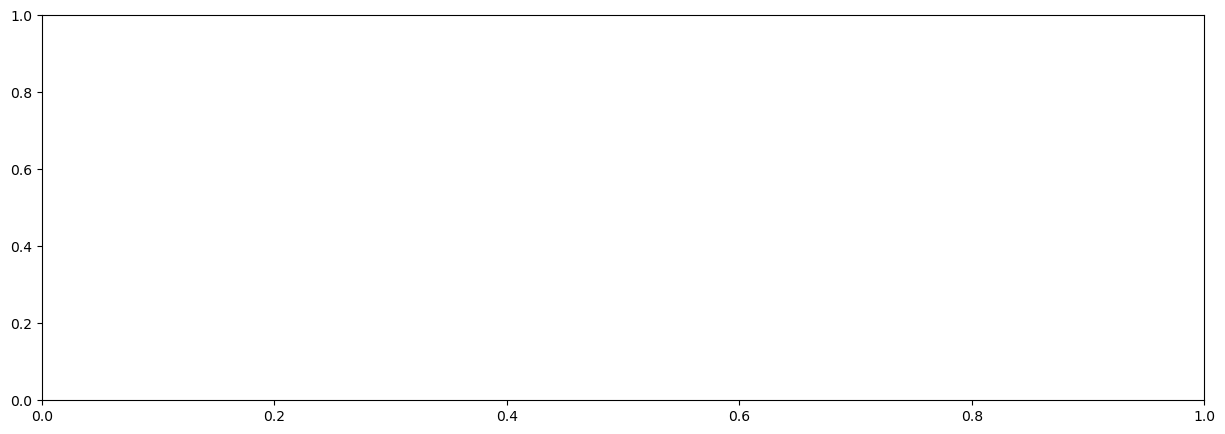

In [ ]:
# title = "Mean cosine sim"
# metric_keys = ["mean_intra_cluster_cosine_sim", "mean_global_cosine_sim", "mean_inter_cluster_cosine_sim"]

# hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

# plot_models = ['0.1drift_-0.8attention_0retraining_20attributes_15clusters_0surprise_1user-topic-mapping', '0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping']
# num_plots = len(hyper_param_values)
# fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

# for i, param_val in enumerate(hyper_param_values):
#     print(f"\n{graph_by_hyper_param}={param_val}")
#     graph_metrics_by_axis(axs[i], results, metric_keys[0], [plot_models[i]], id_to_readable, label="by_metric")
#     graph_metrics_by_axis(axs[i], results, metric_keys[1], [plot_models[i]], id_to_readable, label="by_metric")
#     graph_metrics_by_axis(axs[i], results, metric_keys[2], [plot_models[i]], id_to_readable, label="by_metric")
#     axs[i].set_ylabel(y_labels[metric_key])
#     axs[i].set_xlabel("Timestep")
#     axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
#     axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)



repeated_training=0
mean_intra_cluster_cosine_sim 0.54937
mean_global_cosine_sim 0.54953
mean_inter_cluster_cosine_sim 0.54433

repeated_training=1
mean_intra_cluster_cosine_sim 0.81774
mean_global_cosine_sim 0.81800
mean_inter_cluster_cosine_sim 0.80838


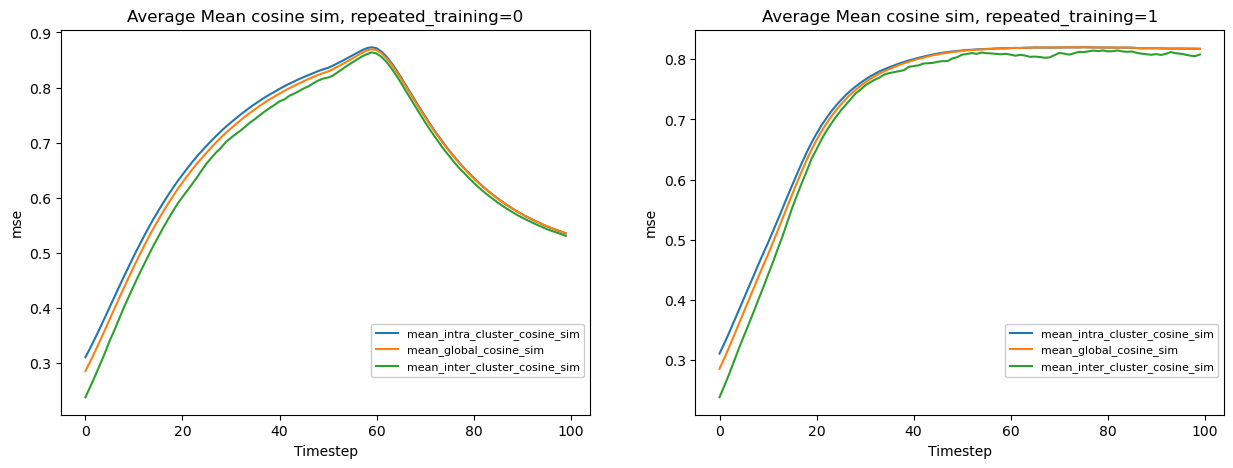

In [ ]:
title = "Mean cosine sim"
metric_keys = ["mean_intra_cluster_cosine_sim", "mean_global_cosine_sim", "mean_inter_cluster_cosine_sim"]

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[0], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[1], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[2], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)

# print()
# a1 = 0.67988
# a2 = 0.66363
# print("diff=", "{0:.5f}".format(a1-a2))
# print("normalized diff=", "{0:.5f}".format((a1-a2)/a1))

# print()
# b1 = 0.68722
# b2 = 0.68908
# print("diff=", "{0:.5f}".format(b1-b2))
# print("normalized diff=", "{0:.5f}".format((b1-b2)/b1))

## `Interaction similarity`


repeated_training=0
intra_cluster_interaction_similarity 0.05702
global_interaction_similarity 0.05630
inter_cluster_interaction_similarity 0.05512

repeated_training=1
intra_cluster_interaction_similarity 0.03625
global_interaction_similarity 0.03612
inter_cluster_interaction_similarity 0.03579

diff= 0.00138
normalized diff= 0.02897

diff= 0.00097
normalized diff= 0.02126


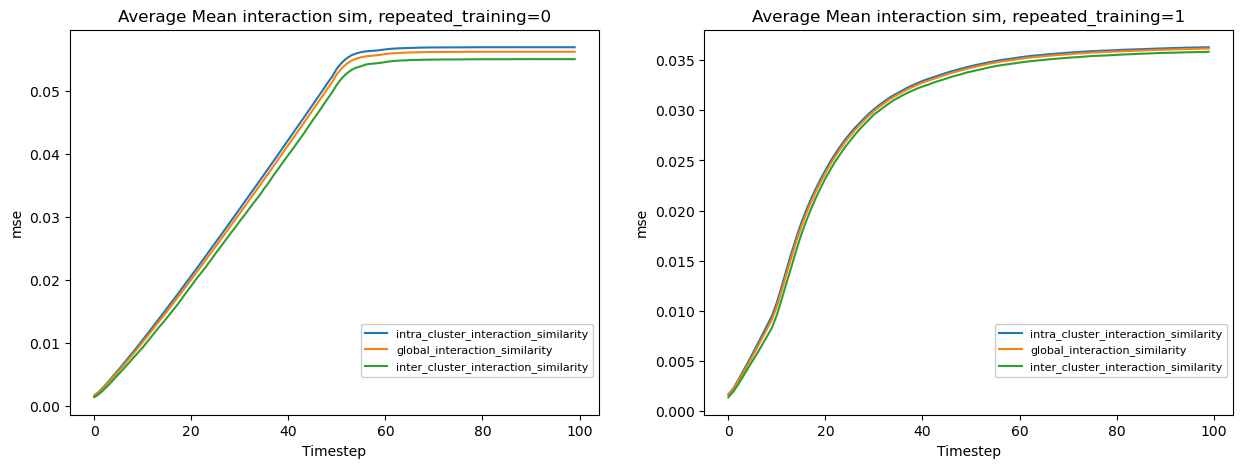

In [ ]:
title = "Mean interaction sim"
metric_keys = ["intra_cluster_interaction_similarity", "global_interaction_similarity", "inter_cluster_interaction_similarity"]

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[0], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[1], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[2], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)
    
print()
a1 = 0.04763
a2 = 0.04625
print("diff=", "{0:.5f}".format(a1-a2))
print("normalized diff=", "{0:.5f}".format((a1-a2)/a1))

print()
b1 = 0.04563
b2 = 0.04466
print("diff=", "{0:.5f}".format(b1-b2))
print("normalized diff=", "{0:.5f}".format((b1-b2)/b1))

In [ ]:
def graph_metrics_difference_by_axis(ax, train_results, larger_metric, smaller_metric, model_keys, label_map, mean_sigma=0, mult_sd=0, conf_sigma=0, normalized=True, label=""):
    for m in model_keys:
        if not isinstance(train_results[metric_key][m], np.ndarray):
            train_results[metric_key][m] = np.array(train_results[metric_key][m])
        # average across trials and smooth, if necessary
        larger_values = np.array(train_results[larger_metric][m])
        smaller_values = np.array(train_results[smaller_metric][m])
        difference = larger_values - smaller_values
        if normalized:
            difference = np.divide(difference, larger_values)
        if mean_sigma > 0:
            values = gaussian_filter1d(difference.mean(axis=0), sigma=mean_sigma)
        else:
            values = difference.mean(axis=0)
        
        if label == "by_params":
            line_label = label_map[m]
        elif label == "by_metric":
            line_label = metric_key
        else:
            line_label = label
        line = ax.plot(values, label=line_label)
        line_color = line[0].get_color()
        if mult_sd > 0:
            std = train_results[metric_key][m].std(axis=0)
            timesteps = np.arange(len(std))
            low = values - mult_sd * std
            high = values + mult_sd * std
            if conf_sigma > 0:
                low = gaussian_filter1d(low, sigma=conf_sigma)
                high = gaussian_filter1d(high, sigma=conf_sigma)
            ax.fill_between(timesteps, low, high, color = line_color, alpha=0.3)
    ax.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5))
    return ax

## `Centroid distance`


repeated_training=0
mean_global_distance_from_centroid 1.06049
mean_cluster_distance_from_centroid 0.76060

repeated_training=1


mean_global_distance_from_centroid 1.00342
mean_cluster_distance_from_centroid 0.72686

diff= 0.30965
normalized diff= 0.28978

diff= 0.26680
normalized diff= 0.26805


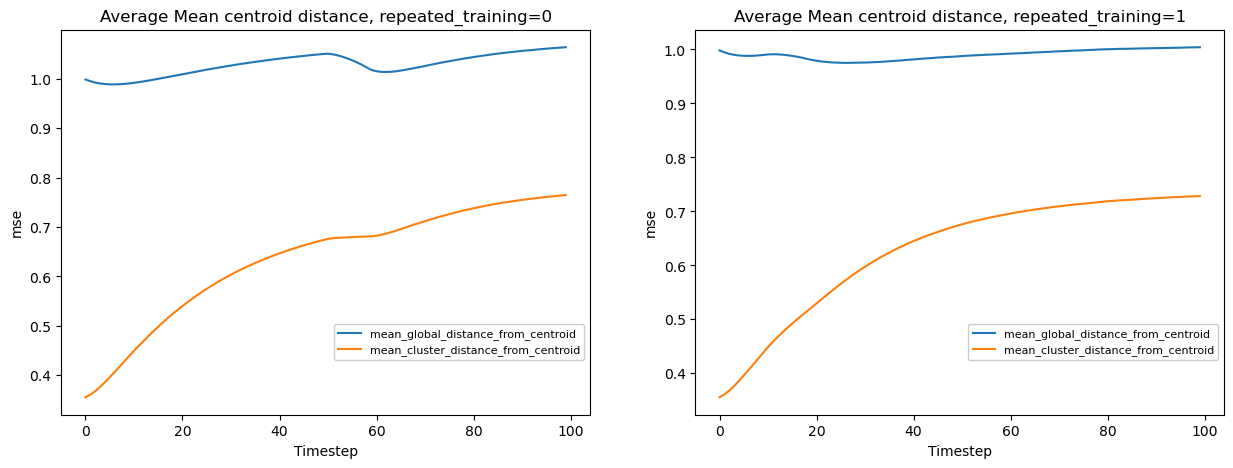

In [ ]:
title = "Mean centroid distance"
metric_keys = ["mean_global_distance_from_centroid", "mean_cluster_distance_from_centroid"]

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[0], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[1], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)

print()
a1 = 1.06857
a2 = 0.75892
print("diff=", "{0:.5f}".format(a1-a2))
print("normalized diff=", "{0:.5f}".format((a1-a2)/a1))

print()
b1 = 0.99534
b2 = 0.72854
print("diff=", "{0:.5f}".format(b1-b2))
print("normalized diff=", "{0:.5f}".format((b1-b2)/b1))

In [ ]:
# print(results.keys())
# # results["mean_distance_from_centroid_per_cluster"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]
# test_results["mean_distance_from_centroid_per_cluster"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]

### Checking `InteractionMeasurement`

In [ ]:
# # results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

# test_results_path = ["prelim_exp_results/test_interaction_measurement"]
# results_file = ["sim_results.pkl"]

# test_results = merge_results(test_results_path, results_file)
# print("# metrics =", len(test_results.keys()))
# print(test_results.keys(), "\n")

# test_results["interaction_measurement"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]##'0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping'

## Checking `environment` variable results

In [ ]:
# # results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

# results_path = ["prelim_exp_results/10train90run", "prelim_exp_results/50train50run"]
# environment_file = ["sim_environment.pkl", "sim_environment.pkl"]

# environments = merge_results(results_path, environment_file)

In [ ]:
# environments.keys()

In [ ]:
# user_representation = environments["actual_user_representation_initial"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
# item_cluster_centers = environments["item_cluster_centroids"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
# user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers)
# # inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_item_cluster_mapping)

In [ ]:
# print(user_item_cluster_mapping.shape)
# print(user_item_cluster_mapping[:15])
# sim_mapping = environments["user_item_cluster_mapping"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
# print(sim_mapping.shape)
# print(sim_mapping[:15])
# np.array_equal(user_item_cluster_mapping, sim_mapping)

In [ ]:
# final_user_representation = environments["actual_user_representation_final"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
# item_cluster_centers = environments["item_cluster_centroids"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
# final_user_item_cluster_mapping = user_topic_mapping(final_user_representation, item_cluster_centers)
# print(final_user_item_cluster_mapping.shape)
# print(final_user_item_cluster_mapping[:15])

## Checking `diagnostics` results

In [ ]:
# # results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

# # test_results_path = ["prelim_exp_results/test_interaction_measurement"]
# test_results_path = ["/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/sim_experiments/sim_results/tester"]
# diagnostics_file = ["sim_diagnostics.pkl"]

# # diagnostics = load_sim_results(test_results_path[0], diagnostics_file[0])
# diagnostics = merge_results(test_results_path, diagnostics_file)
# diagnostics

In [ ]:
# print(diagnostics.keys())
# print(diagnostics["mean_global_cosine_sim"].keys())
# print(diagnostics["mean_global_cosine_sim"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"].keys())
# print(diagnostics["mean_global_cosine_sim"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]["max"])

In [ ]:
# # results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

# test_results_path = ["prelim_exp_results/test_interaction_measurement"]
# test_results_file = ["sim_results.pkl"]

# test_results = load_sim_results(test_results_path[0], test_results_file[0])

# print(test_results.keys())
# print(test_results["mean_global_cosine_sim"].keys())
# print(test_results["mean_global_cosine_sim"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"])
# # print(test_results["mean_global_cosine_sim"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]["mean"])